In [ ]:
import torch
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001

class LARS(Optimizer):
    def __init__(self, params, lr=required, momentum=0.9, use_nesterov=False, weight_decay=0.0, exclude_from_weight_decay=None, exclude_from_layer_adaptation=None, classic_momentum=True, eeta=EETA_DEFAULT):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """
        self.epoch = 0
        defaults = dict(lr=lr, momentum=momentum, use_nesterov=use_nesterov, weight_decay=weight_decay, exclude_from_weight_decay=exclude_from_weight_decay,
                        exclude_from_layer_adaptation=exclude_from_layer_adaptation, classic_momentum=classic_momentum, eeta=eeta)
        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.ge(0),
                        torch.where(g_norm.ge(0), (self.eeta * w_norm / g_norm), torch.Tensor([1.0]).to(device)),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

In [ ]:
import torch.nn as nn


class LogisticRegression(nn.Module):
    def __init__(self, n_features, n_classes):
        super(LogisticRegression, self).__init__()
        self.fc = nn.Linear(n_features, n_classes)

    def forward(self, x):
        return self.fc(x)

In [ ]:
import numpy as np
import torch

# InfoNCE Lower bound
def InfoNCE(mu, z):
    mu = mu.unsqueeze(0)
    z = z.unsqueeze(1)
    score = -((z-mu)**2).sum(-1)/20.  # 80 for ImageNet
    lower_bound = -score.logsumexp(dim=1).mean()
    return lower_bound

# def InfoNCE(mu, z):
#     AA = (mu*mu).sum(1).unsqueeze(0)
#     BB = (z*z).sum(1, keepdims=True)
#     AB = torch.mm(z, mu.transpose(0, 1))
#     score = -(AA-2.*AB+BB)/80.  # 80 for ImageNet
#     lower_bound = -score.logsumexp(dim=1).mean()
#     return lower_bound

In [ ]:
import torch
import torch.nn as nn

def gen_mask(k, feat_dim):
    mask = None
    for i in range(k):
        tmp_mask = torch.triu(torch.randint(0, 2, (feat_dim, feat_dim)), 1)
        tmp_mask = tmp_mask + torch.triu(1-tmp_mask,1).t()
        tmp_mask = tmp_mask.view(tmp_mask.shape[0], tmp_mask.shape[1],1)
        mask = tmp_mask if mask is None else torch.cat([mask,tmp_mask],2)
    return mask

def entropy(prob):
    # assume m x m x k input
    return -torch.sum(prob*torch.log(prob),1)

class NT_Xent(nn.Module):
    def __init__(self, batch_size, temperature, mask):
        super(NT_Xent, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.mask = mask
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        p1 = torch.cat((z_i, z_j), dim=0)
        sim = self.similarity_f(p1.unsqueeze(1), p1.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)

        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(self.batch_size * 2, 1)
        negative_samples = sim[self.mask].reshape(self.batch_size * 2, -1)

        labels = torch.zeros(self.batch_size * 2).long().cuda()
        logits = torch.cat((positive_samples, negative_samples), dim=1)

        loss = self.criterion(logits, labels)
        loss /= 2 * self.batch_size
        
        return loss


In [ ]:
import torch.nn as nn

class Lambda(nn.Module):
    def __init__(self, func):
        super(Lambda, self).__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class ReCon32(nn.Module):
    def __init__(self, indim=512):
        super(ReCon32, self).__init__()
        self.indim = indim
        self.recon = nn.Sequential(
            nn.Linear(indim, 16*64, bias=False),
            nn.BatchNorm1d(num_features=16*64),
            nn.ReLU(inplace=True),
            Lambda(lambda x: x.reshape(-1, 64, 4, 4)),

            nn.ConvTranspose2d(in_channels=64, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1, output_padding=0, bias=True))

    def forward(self, x):
        out = self.recon(x)
        return out

class ReCon64(nn.Module):
    def __init__(self, indim=512):
        super(ReCon64, self).__init__()
        self.indim = indim
        self.recon = nn.Sequential(
            nn.Linear(indim, 16*128, bias=False),
            nn.BatchNorm1d(num_features=16*128),
            nn.ReLU(inplace=True),
            Lambda(lambda x: x.reshape(-1, 128, 4, 4)),

            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=3, stride=1, padding=1, output_padding=0, bias=True))

    def forward(self, x):
        out = self.recon(x)
        return out

class ReCon224(nn.Module):
    def __init__(self, indim=2048):
        super(ReCon224, self).__init__()
        self.indim = indim
        self.recon = nn.Sequential(
            nn.Linear(indim, 49*64, bias=False),
            nn.BatchNorm1d(num_features=49*64),
            nn.ReLU(inplace=True),
            Lambda(lambda x: x.reshape(-1, 64, 7, 7)),

            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True))

    def forward(self, x):
        out = self.recon(x)
        return out

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        if self.downsample: 
            self.ds_conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
            self.ds_bn1 = nn.BatchNorm2d(planes)
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.ds_bn1(self.ds_conv1(x))
        out += residual
        out = self.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=False):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        if self.downsample:
            self.ds_conv1 = nn.Conv2d(inplanes, planes * self.expansion, kernel_size=1, stride=stride, bias=False)
            self.ds_bn1 = nn.BatchNorm2d(planes * self.expansion)
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample:
            residual = self.ds_bn1(self.ds_conv1(x))

        out += residual
        out = self.relu(out)
        return out

class ResNet_imgnet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet_imgnet, self).__init__()
        self.inplanes = 64       
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)            
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.5)
        self.feat_dim = 512 * block.expansion
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = False
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = True
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)    
        x = self.relu(x)
        x = self.maxpool(x)

        layer1 = self.layer1(x)
        layer2 = self.layer2(layer1)
        out2 = self.avgpool(layer2).squeeze()
        layer3 = self.layer3(layer2)
        out3 = self.avgpool(layer3).squeeze()
        layer4 = self.layer4(layer3)
        out4 = self.avgpool(layer4).squeeze()
        return out2, out3, out4


def resnet18_imagenet():
    return ResNet_imgnet(BasicBlock, [2, 2, 2, 2])

def resnet34_imagenet():
    return ResNet_imgnet(BasicBlock, [3, 4, 6, 3])

def resnet50_imagenet():
    return ResNet_imgnet(Bottleneck, [3, 4, 6, 3])

def resnet101_imagenet():
    return ResNet_imgnet(Bottleneck, [3, 4, 23, 3])

def resnet152_imagenet():
    return ResNet_imgnet(Bottleneck, [3, 8, 36, 3])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Normalize(nn.Module):
    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power
    
    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1./self.power)
        out = x.div(norm)
        return out

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        self.shortcut_bn = None
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False))
            self.shortcut_bn = nn.BatchNorm2d(self.expansion*planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.conv2(out)
        out = self.bn2(out)
        if self.shortcut_bn:
            out += self.shortcut_bn(self.shortcut(x))
        else:
            out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        self.shortcut_bn = None
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False))
            self.shortcut_bn = nn.BatchNorm2d(self.expansion*planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        if self.shortcut_bn:
            out += self.shortcut_bn(self.shortcut(x))
        else:
            out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, data='CIFAR10'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        if data == 'STL-10':
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        else:  # CIFAR10
            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.feat_dim = 512*block.expansion

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        layer1 = self.layer1(out)
        layer2 = self.layer2(layer1)
        out2 = self.avgpool(layer2).squeeze()
        layer3 = self.layer3(layer2)
        out3 = self.avgpool(layer3).squeeze()
        layer4 = self.layer4(layer3)
        out4 = self.avgpool(layer4).squeeze()
        return out2, out3, out4


def resnet18(data='CIFAR10'):
    return ResNet(BasicBlock, [2, 2, 2, 2], data=data)

def resnet34(data='CIFAR10'):
    return ResNet(BasicBlock, [3, 4, 6, 3], data=data)

def resnet50(data='CIFAR10'):
    return ResNet(Bottleneck, [3, 4, 6, 3], data=data)

def resnet101(data='CIFAR10'):
    return ResNet(Bottleneck, [3, 4, 23, 3], data=data)

def resnet152(data='CIFAR10'):
    return ResNet(Bottleneck, [3, 8, 36, 3], data=data)

In [ ]:
import torch.nn as nn
import torchvision
class SimCLR(nn.Module):
    """
    We opt for simplicity and adopt the commonly used ResNet to obtain hi = f(xi) = ResNet(xi) where hi is the output after the average pooling layer.
    """
    def __init__(self, args, data='non_imagenet'):
        super(SimCLR, self).__init__()
        self.args = args
        if data == 'imagenet':
            self.encoder = self.get_imagenet_resnet(args.resnet)
        else:
            self.encoder = self.get_resnet(args.resnet)

        self.n_features = self.encoder.feat_dim
        self.projector = nn.Sequential(nn.Linear(self.n_features, self.n_features),
                                       nn.ReLU(),
                                       nn.Linear(self.n_features, args.projection_dim))

    def get_resnet(self, name):
        resnets = {
            "resnet18": resnet18(data=self.args.dataset),
            "resnet34": resnet34(data=self.args.dataset),
            "resnet50": resnet50(data=self.args.dataset),
            "resnet101": resnet101(data=self.args.dataset),
            "resnet152": resnet152(data=self.args.dataset)}
        if name not in resnets.keys():
            raise KeyError(f"{name} is not a valid ResNet version")
        return resnets[name]
     
    def get_imagenet_resnet(self, name):
        resnets = {
            "resnet18": resnet18_imagenet(),
            "resnet34": resnet34_imagenet(),
            "resnet50": resnet50_imagenet(),
            "resnet101": resnet101_imagenet(),
            "resnet152": resnet152_imagenet()}
        if name not in resnets.keys():
            raise KeyError(f"{name} is not a valid ResNet version")
        return resnets[name]

    def forward(self, x):
        if self.args.model == 'LBE':
            mu2, mu3, mu4 = self.encoder(x)
            esp2 = mu2.data.new(mu2.size()).normal_(0., self.args.zeta)
            h2 = mu2 + esp2
            esp3 = mu3.data.new(mu3.size()).normal_(0., self.args.zeta)
            h3 = mu3 + esp3
            esp4 = mu4.data.new(mu4.size()).normal_(0., self.args.zeta)
            h4 = mu4 + esp4
            z = self.projector(h4)
            if self.args.normalize:
                z = nn.functional.normalize(z, dim=1)
            out = (mu2, mu3, mu4, h2, h3, h4, z)
        elif self.args.model == 'MIB':
            _, _, mu = self.encoder(x)
            esp = mu.data.new(mu.size()).normal_(0., self.args.zeta)
            h = mu + esp
            z = self.projector(h)
            if self.args.normalize:
                z = nn.functional.normalize(z, dim=1)
            out = (mu, h, z)
        else:
            _, _, h = self.encoder(x)
            z = self.projector(h)
            if self.args.normalize:
                z = nn.functional.normalize(z, dim=1)
            out = (h, z)
        return out

In [ ]:
import torchvision

class Transforms:
    """
    A stochastic data augmentation module that transforms any given data example randomly 
    resulting in two correlated views of the same example,
    denoted xi and xj, which we consider as a positive pair.
    """
    def __init__(self, size=32):
        s = 1
        color_jitter = torchvision.transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
        normalize = torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        self.train_transform = torchvision.transforms.Compose([
                torchvision.transforms.RandomResizedCrop(size=size),
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.RandomApply([color_jitter], p=0.8),
                torchvision.transforms.RandomGrayscale(p=0.2),
                torchvision.transforms.ToTensor(),
                normalize])

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

class Transforms_imagenet:
    """
    A stochastic data augmentation module that transforms any given data example randomly 
    resulting in two correlated views of the same example,
    denoted xi and xj, which we consider as a positive pair.
    """
    def __init__(self, size=224):
        s = 1
        color_jitter = torchvision.transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
        normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.train_transform = torchvision.transforms.Compose([
                torchvision.transforms.RandomResizedCrop(size=size),
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.RandomApply([color_jitter], p=0.8),
                torchvision.transforms.RandomGrayscale(p=0.2),
                torchvision.transforms.ToTensor(),
                normalize])

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

In [ ]:
def get_data_mean_and_stdev(dataset):
    if dataset == 'CIFAR10' or dataset == 'CIFAR100':
        mean = [0.5, 0.5, 0.5]
        std  = [0.5, 0.5, 0.5]
    elif dataset == 'STL-10':
        mean = [0.491, 0.482, 0.447]
        std  = [0.247, 0.244, 0.262]
    elif dataset == 'ImageNet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif dataset == 'aircraft':
        mean = [0.486, 0.507, 0.525]
        std  = [0.266, 0.260, 0.276]
    elif dataset == 'cu_birds':
        mean = [0.483, 0.491, 0.424] 
        std  = [0.228, 0.224, 0.259]
    elif dataset == 'dtd':
        mean = [0.533, 0.474, 0.426]
        std  = [0.261, 0.250, 0.259]
    elif dataset == 'fashionmnist':
        mean = [0.348, 0.348, 0.348] 
        std  = [0.347, 0.347, 0.347]
    elif dataset == 'mnist':
        mean = [0.170, 0.170, 0.170]
        std  = [0.320, 0.320, 0.320]
    elif dataset == 'traffic_sign':
        mean = [0.335, 0.291, 0.295]
        std  = [0.267, 0.249, 0.251]
    elif dataset == 'vgg_flower':
        mean = [0.518, 0.410, 0.329]
        std  = [0.296, 0.249, 0.285]
    else:
        raise Exception('Dataset %s not supported.'%dataset)
    return mean, std

def get_data_nclass(dataset):
    if dataset == 'CIFAR10':
        nclass = 10
    elif dataset == 'CIFAR100':
        nclass = 100
    elif dataset == 'STL-10':
        nclass = 10
    elif dataset == 'ImageNet':
        nclass = 1000
    elif dataset == 'aircraft':
        nclass = 102
    elif dataset == 'cu_birds':
        nclass = 200
    elif dataset == 'dtd':
        nclass = 47
    elif dataset == 'fashionmnist':
        nclass = 10
    elif dataset == 'mnist':
        nclass = 10
    elif dataset == 'traffic_sign':
        nclass = 43
    elif dataset == 'vgg_flower':
        nclass = 102
    else:
        raise Exception('Dataset %s not supported.'%dataset)
    return nclass

In [ ]:
import os
os.makedirs("datasets")

In [ ]:
import os
import numpy as np
from PIL import Image
from os.path import join
from collections import defaultdict
import torch.utils.data as data

DATA_ROOTS = 'datasets/Aircraft'

class Aircraft(data.Dataset):
    def __init__(self, root=DATA_ROOTS, train=True, image_transforms=None):
        super().__init__()
        self.root = root
        self.train = train
        self.image_transforms = image_transforms
        paths, bboxes, labels = self.load_images()
        self.paths = paths
        self.bboxes = bboxes
        self.labels = labels

    def load_images(self):
        split = 'trainval' if self.train else 'test'
        variant_path = os.path.join(self.root, 'data', 'images_variant_%s.txt'%split)
        with open(variant_path, 'r') as f:
            names_to_variants = [line.split('\n')[0].split(' ', 1) for line in f.readlines()]
        names_to_variants = dict(names_to_variants)
        variants_to_names = defaultdict(list)
        for name, variant in names_to_variants.items():
            variants_to_names[variant].append(name)
        variants = sorted(list(set(variants_to_names.keys())))

        names_to_bboxes = self.get_bounding_boxes()
        split_files, split_labels, split_bboxes = [], [], []
        for variant_id, variant in enumerate(variants):
            class_files = [join(self.root, 'data', 'images', '%s.jpg'%filename) for filename in sorted(variants_to_names[variant])]
            bboxes = [names_to_bboxes[name] for name in sorted(variants_to_names[variant])]
            labels = list([variant_id] * len(class_files))
            split_files += class_files
            split_labels += labels
            split_bboxes += bboxes
        return split_files, split_bboxes, split_labels

    def get_bounding_boxes(self):
        bboxes_path = os.path.join(self.root, 'data', 'images_box.txt')
        with open(bboxes_path, 'r') as f:
            names_to_bboxes = [line.split('\n')[0].split(' ') for line in f.readlines()]
            names_to_bboxes = dict((name, list(map(int, (xmin, ymin, xmax, ymax)))) for name, xmin, ymin, xmax, ymax in names_to_bboxes)
        return names_to_bboxes

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        bbox = tuple(self.bboxes[index])
        label = self.labels[index]

        image = Image.open(path).convert(mode='RGB')
        image = image.crop(bbox)

        if self.image_transforms:
            image = self.image_transforms(image)
        return image, label

In [ ]:
import os
import numpy as np
from PIL import Image
import torch.utils.data as data

DATA_ROOTS = 'datasets/CUBirds'

class CUBirds(data.Dataset):
    def __init__(self, root=DATA_ROOTS, train=True, image_transforms=None):
        super().__init__()
        self.root = root
        self.train = train
        self.image_transforms = image_transforms
        paths, labels = self.load_images()
        self.paths, self.labels = paths, labels

    def load_images(self):
        image_info_path = os.path.join(self.root, 'images.txt')
        with open(image_info_path, 'r') as f:
            image_info = [line.split('\n')[0].split(' ', 1) for line in f.readlines()]
        image_info = dict(image_info)

        # load image to label information
        label_info_path = os.path.join(self.root, 'image_class_labels.txt')
        with open(label_info_path, 'r') as f:
            label_info = [line.split('\n')[0].split(' ', 1) for line in f.readlines()]
        label_info = dict(label_info)

        # load train test split
        train_test_info_path = os.path.join(self.root, 'train_test_split.txt')
        with open(train_test_info_path, 'r') as f:
            train_test_info = [line.split('\n')[0].split(' ', 1) for line in f.readlines()]
        train_test_info = dict(train_test_info)

        all_paths, all_labels = [], []
        for index, image_path in image_info.items():
            label = label_info[index]
            split = int(train_test_info[index])
            if self.train:
                if split == 1:
                    all_paths.append(image_path)
                    all_labels.append(label)
            else:
                if split == 0:
                    all_paths.append(image_path)
                    all_labels.append(label)
        return all_paths, all_labels

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = os.path.join(self.root, 'images', self.paths[index])
        label = int(self.labels[index]) - 1
        image = Image.open(path).convert(mode='RGB')
        if self.image_transforms:
            image = self.image_transforms(image)
        return image, label

In [ ]:
import os
import copy
import numpy as np
from PIL import Image
from os.path import join
from itertools import chain
from collections import defaultdict

import torch
import torch.utils.data as data
from torchvision import transforms

DATA_ROOTS = 'datasets/DTD'

class DTD(data.Dataset):
    def __init__(self, root=DATA_ROOTS, train=True, image_transforms=None):
        super().__init__()
        self.root = root
        self.train = train
        self.image_transforms = image_transforms
        paths, labels = self.load_images()
        self.paths, self.labels = paths, labels

    def load_images(self):
        if self.train:
            train_info_path = os.path.join(self.root, 'labels', 'train1.txt')
            with open(train_info_path, 'r') as f:
                train_info = [line.split('\n')[0] for line in f.readlines()]

            val_info_path = os.path.join(self.root, 'labels', 'val1.txt')
            with open(val_info_path, 'r') as f:
                val_info = [line.split('\n')[0] for line in f.readlines()]
            split_info = train_info + val_info

        else:
            test_info_path = os.path.join(self.root, 'labels', 'test1.txt')
            with open(test_info_path, 'r') as f:
                split_info = [line.split('\n')[0] for line in f.readlines()]

        # pull out categoires from paths
        categories = []
        for row in split_info:
            image_path = row
            category = image_path.split('/')[0]
            categories.append(category)
        categories = sorted(list(set(categories)))

        all_paths, all_labels = [], []
        for row in split_info:
            image_path = row
            category = image_path.split('/')[0]
            label = categories.index(category)
            all_paths.append(join(self.root, 'images', image_path))
            all_labels.append(label)
        return all_paths, all_labels

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        label = self.labels[index]
        image = Image.open(path).convert(mode='RGB')
        if self.image_transforms:
            image = self.image_transforms(image)
        return image, label

In [ ]:
import os
import copy
from PIL import Image
import numpy as np

import torch
import torch.utils.data as data
from torchvision import transforms, datasets

DATA_ROOTS = 'datasets'

class FashionMNIST(data.Dataset):
    def __init__(self, root=DATA_ROOTS, train=True, image_transforms=None):
        super().__init__()
        if not os.path.isdir(root):
            os.makedirs(root)
        self.image_transforms = image_transforms
        self.dataset = datasets.mnist.FashionMNIST(root, train=train, download=True)

    def __getitem__(self, index):
        img, target = self.dataset.data[index], int(self.dataset.targets[index])
        img = Image.fromarray(img.numpy(), mode='L').convert('RGB')
        if self.image_transforms is not None:
            img = self.image_transforms(img)
        return img, target

    def __len__(self):
        return len(self.dataset)

In [ ]:
import os
import copy
from PIL import Image
import numpy as np

import torch
import torch.utils.data as data
from torchvision import transforms, datasets

DATA_ROOTS = 'datasets'

class MNIST(data.Dataset):
    def __init__(self, root=DATA_ROOTS, train=True, image_transforms=None):
        super().__init__()
        if not os.path.isdir(root):
            os.makedirs(root)
        self.image_transforms = image_transforms
        self.dataset = datasets.mnist.MNIST(root, train=train, download=True)

    def __getitem__(self, index):
        img, target = self.dataset.data[index], int(self.dataset.targets[index])
        img = Image.fromarray(img.numpy(), mode='L').convert('RGB')
        if self.image_transforms is not None:
            img = self.image_transforms(img)
        return img, target

    def __len__(self):
        return len(self.dataset)

In [ ]:
import os
import copy
import json
import operator
import numpy as np
from PIL import Image
from glob import glob
from os.path import join
from itertools import chain
from scipy.io import loadmat
from collections import defaultdict

import torch
import torch.utils.data as data
from torchvision import transforms

DATA_ROOTS = 'datasets/TrafficSign'

class TrafficSign(data.Dataset):
    NUM_CLASSES = 43
    def __init__(self, root=DATA_ROOTS, train=True, image_transforms=None):
        super().__init__()
        self.root = root
        self.train = train
        self.image_transforms = image_transforms
        paths, labels = self.load_images()
        self.paths, self.labels = paths, labels

    def load_images(self):
        split = 'Final_Training'
        rs = np.random.RandomState(42)
        all_filepaths, all_labels = [], []
        for class_i in range(self.NUM_CLASSES):
            class_dir_i = join(self.root, split, 'Images', '{:05d}'.format(class_i))
            image_paths = glob(join(class_dir_i, "*.ppm"))
            # train test splitting
            image_paths = np.array(image_paths)
            num = len(image_paths)
            indexer = np.arange(num)
            rs.shuffle(indexer)
            image_paths = image_paths[indexer].tolist()
            if self.train:
                image_paths = image_paths[:int(0.8 * num)]
            else:
                image_paths  = image_paths[int(0.8 * num):]
            labels = [class_i] * len(image_paths)
            all_filepaths.extend(image_paths)
            all_labels.extend(labels)

        return all_filepaths, all_labels

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        label = self.labels[index]
        image = Image.open(path).convert(mode='RGB')
        if self.image_transforms:
            image = self.image_transforms(image)
        return image, label

In [ ]:
import os
import copy
import json
import operator
import numpy as np
from PIL import Image
from os.path import join
from itertools import chain
from scipy.io import loadmat
from collections import defaultdict

import torch
import torch.utils.data as data
from torchvision import transforms

DATA_ROOTS = 'datasets/VGGFlower'

class VGGFlower(data.Dataset):
    def __init__(self, root=DATA_ROOTS, train=True, image_transforms=None):
        super().__init__()
        self.root = root
        self.train = train
        self.image_transforms = image_transforms
        paths, labels = self.load_images()
        self.paths, self.labels = paths, labels

    def load_images(self):
        rs = np.random.RandomState(42)
        imagelabels_path = os.path.join(self.root, 'imagelabels.mat')
        with open(imagelabels_path, 'rb') as f:
            labels = loadmat(f)['labels'][0]

        all_filepaths = defaultdict(list)
        for i, label in enumerate(labels):
            all_filepaths[label].append(os.path.join(self.root, 'jpg', 'image_{:05d}.jpg'.format(i+1)))
        # train test split
        split_filepaths, split_labels = [], []
        for label, paths in all_filepaths.items():
            num = len(paths)
            paths = np.array(paths)
            indexer = np.arange(num)
            rs.shuffle(indexer)
            paths = paths[indexer].tolist()

            if self.train:
                paths = paths[:int(0.8 * num)]
            else:
                paths = paths[int(0.8 * num):]

            labels = [label] * len(paths)
            split_filepaths.extend(paths)
            split_labels.extend(labels)
        
        return split_filepaths, split_labels

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        label = int(self.labels[index]) - 1
        image = Image.open(path).convert(mode='RGB')
        if self.image_transforms:
            image = self.image_transforms(image)
        return image, label

In [ ]:
DATASET = {
    'aircraft': Aircraft,
    'cu_birds': CUBirds,
    'dtd': DTD,
    'fashionmnist': FashionMNIST,
    'mnist': MNIST,
    'traffic_sign': TrafficSign,
    'vgg_flower': VGGFlower}

In [ ]:
def get_data_mean_and_stdev(dataset):
    if dataset == 'CIFAR10' or dataset == 'CIFAR100':
        mean = [0.5, 0.5, 0.5]
        std  = [0.5, 0.5, 0.5]
    elif dataset == 'STL-10':
        mean = [0.491, 0.482, 0.447]
        std  = [0.247, 0.244, 0.262]
    elif dataset == 'ImageNet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif dataset == 'aircraft':
        mean = [0.486, 0.507, 0.525]
        std  = [0.266, 0.260, 0.276]
    elif dataset == 'cu_birds':
        mean = [0.483, 0.491, 0.424] 
        std  = [0.228, 0.224, 0.259]
    elif dataset == 'dtd':
        mean = [0.533, 0.474, 0.426]
        std  = [0.261, 0.250, 0.259]
    elif dataset == 'fashionmnist':
        mean = [0.348, 0.348, 0.348] 
        std  = [0.347, 0.347, 0.347]
    elif dataset == 'mnist':
        mean = [0.170, 0.170, 0.170]
        std  = [0.320, 0.320, 0.320]
    elif dataset == 'traffic_sign':
        mean = [0.335, 0.291, 0.295]
        std  = [0.267, 0.249, 0.251]
    elif dataset == 'vgg_flower':
        mean = [0.518, 0.410, 0.329]
        std  = [0.296, 0.249, 0.285]
    else:
        raise Exception('Dataset %s not supported.'%dataset)
    return mean, std

def get_data_nclass(dataset):
    if dataset == 'CIFAR10':
        nclass = 10
    elif dataset == 'CIFAR100':
        nclass = 100
    elif dataset == 'STL-10':
        nclass = 10
    elif dataset == 'ImageNet':
        nclass = 1000
    elif dataset == 'aircraft':
        nclass = 102
    elif dataset == 'cu_birds':
        nclass = 200
    elif dataset == 'dtd':
        nclass = 47
    elif dataset == 'fashionmnist':
        nclass = 10
    elif dataset == 'mnist':
        nclass = 10
    elif dataset == 'traffic_sign':
        nclass = 43
    elif dataset == 'vgg_flower':
        nclass = 102
    else:
        raise Exception('Dataset %s not supported.'%dataset)
    return nclass

In [ ]:
import torch

def mask_correlated_samples(batch_size):
    mask = torch.ones((batch_size*2, batch_size*2)).bool()
    mask = mask.fill_diagonal_(0)
    for i in range(batch_size):
        mask[i, batch_size+i] = 0
        mask[batch_size+i, i] = 0
    return mask


In [ ]:
import os
import torch


def load_model(args, reload_model=False, load_path=None, data='non_imagenet'):
    model = SimCLR(args, data=data)
    if reload_model:
        if os.path.isfile(load_path):
            model_fp = os.path.join(load_path)
        else:
            print("No file to load")
            return
        model.load_state_dict(torch.load(model_fp, map_location=lambda storage, loc: storage))
    model = model.cuda()

    if args.model == 'RC':
        if args.dataset == 'STL-10':
            recon = ReCon64(512).cuda()
        elif args.dataset == 'ImageNet':
            recon = ReCon224(2048).cuda()
        else:
            recon = ReCon32(512).cuda()
        params = [{'params': model.parameters()}, {'params': recon.parameters()}]
    else:
        recon = None
        params = model.parameters()

    scheduler = None
    if args.optimizer == "Adam":
        optimizer = torch.optim.Adam(params, lr=args.lr)
    elif args.optimizer == "LARS":
        # LearningRate=(0.3×BatchSize/256) and weight decay of 10−6.
        learning_rate = 0.3 * args.batch_size / 256
        optimizer = LARS(params, lr=learning_rate, weight_decay=args.weight_decay, exclude_from_weight_decay=["batch_normalization", "bias"])
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs, eta_min=0, last_epoch=-1)
    else:
        raise NotImplementedError

    return model, recon, optimizer, scheduler


def save_model(model_dir, model, epoch):
    if isinstance(model, torch.nn.DataParallel):
        torch.save(model.module.state_dict(), model_dir + '_epoch_{}.pt'.format(epoch))
    else:
        torch.save(model.state_dict(), model_dir + '_epoch_{}.pt'.format(epoch))

In [ ]:
import os
import torch
import torchvision
import torch.nn.functional as F
import argparse


import sys
sys.argv=['']


parser = argparse.ArgumentParser(description='SimCLR')
parser.add_argument('--model', default="orig", type=str, help="orig/RC/LBE/IP/MIB")
parser.add_argument('--batch_size', default=256, type=int, metavar='B', help='training batch size')
parser.add_argument('--workers', default=2, type=int, help='workers')
parser.add_argument('--epochs', default=30, type=int, help='epochs')
parser.add_argument('--save_freq', default=20, type=int, help='save frequency')
parser.add_argument('--resnet', default="resnet18", type=str, help="resnet18/resnet34/resnet50/resnet101/resnet152")
parser.add_argument('--normalize', default=True, action='store_true', help='normalize')
parser.add_argument('--projection_dim', default=128, type=int, help='projection_dim')
parser.add_argument('--lamb', default=1., type=float, help='weight of regularization term')
parser.add_argument('--zeta', default=0.1, type=float, help='variance')
parser.add_argument('--optimizer', default="Adam", type=str, help="optimizer")
parser.add_argument('--lr', default=3e-4, type=float, help='lr')
parser.add_argument('--weight_decay', default=1e-6, type=float, help='weight_decay')
parser.add_argument('--temperature', default=0.5, type=float, help='temperature')
parser.add_argument('--gpus', default=8, type=int, help='number of gpu')
parser.add_argument('--model_dir', default='output/checkpoint/', type=str, help='model save path')
parser.add_argument('--dataset', default='CIFAR10', help='[CIFAR10, CIFAR100, ImageNet, STL-10]')
args = parser.parse_args()


def train(train_loader, model, recon, criterion, optimizer):
    loss_epoch = 0.
    for step, ((x_i, x_j), _) in enumerate(train_loader):
        x_i, x_j = x_i.cuda(), x_j.cuda()
        optimizer.zero_grad()
        if args.model == 'orig':
            _, z_i = model(x_i)
            _, z_j = model(x_j)
            loss = criterion(z_i, z_j)
        elif args.model == 'RC':
            h_i, z_i = model(x_i)
            h_j, z_j = model(x_j)
            recon_loss = F.mse_loss(recon(h_i), x_i) + F.mse_loss(recon(h_j), x_j)
            loss = criterion(z_i, z_j) + args.lamb * recon_loss
        elif args.model == 'LBE':
            mu2_i, mu3_i, mu4_i, h2_i, h3_i, h4_i, z_i = model(x_i)
            mu2_j, mu3_j, mu4_j, h2_j, h3_j, h4_j, z_j = model(x_j)
            mu2, h2 = torch.cat([mu2_i, mu2_j], dim=0), torch.cat([h2_i, h2_j], dim=0)
            mu3, h3 = torch.cat([mu3_i, mu3_j], dim=0), torch.cat([h3_i, h3_j], dim=0)
            mu4, h4 = torch.cat([mu4_i, mu4_j], dim=0), torch.cat([h4_i, h4_j], dim=0)
            if args.dataset == "ImageNet":
                MI_estimitor = InfoNCE(mu4, h4)
            else:
                MI_estimitor = 0.25 * InfoNCE(mu2, h2) + 0.50 * InfoNCE(mu3, h3) + InfoNCE(mu4, h4)
            loss = criterion(z_i, z_j) - args.lamb * MI_estimitor
        elif args.model == 'IP':
            h_i, z_i = model(x_i)
            h_j, z_j = model(x_j)
            IP = F.mse_loss(h_i, h_j)
            loss = criterion(z_i, z_j) + args.lamb * IP
        elif args.model == 'MIB':
            mu_i, _, z_i = model(x_i)
            mu_j, _, z_j = model(x_j)
            MIB = F.mse_loss(mu_i, mu_j)
            loss = criterion(z_i, z_j) + args.lamb * MIB
        else:
            assert False
        loss.backward()
        optimizer.step()

        if step % 50 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {loss.item()}")
        loss_epoch += loss.item()
    return loss_epoch


def main():
    data = 'non_imagenet'
    root = "datasets"
    if args.dataset == "CIFAR10":
        train_dataset = torchvision.datasets.CIFAR10(root, download=True, transform=Transforms(32))
    elif args.dataset == "CIFAR100":
        train_dataset = torchvision.datasets.CIFAR100(root, download=True, transform=Transforms(32))
    elif args.dataset == "STL-10":
        train_dataset = torchvision.datasets.STL10(root, split='unlabeled', download=True, transform=Transforms(64))
    elif args.dataset == "ImageNet":
        traindir = os.path.join(root, 'ImageNet/train')
        train_dataset = torchvision.datasets.ImageFolder(traindir, Transforms_imagenet(size=224))
        data = 'imagenet'
    else:
        raise NotImplementedError

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=args.workers,
        sampler=None)

    log_dir = "output/log/" + args.dataset + '_%s/'%args.model
    if not os.path.isdir(log_dir):
        os.makedirs(log_dir)

    suffix = args.dataset + '_{}_batch_{}'.format(args.resnet, args.batch_size)
    suffix = suffix + '_proj_dim_{}'.format(args.projection_dim)
    test_log_file = open(log_dir + suffix + '.txt', "w")

    model, recon, optimizer, scheduler = load_model(args, data=data)
    if args.dataset=='ImageNet':
        model = torch.nn.DataParallel(model, device_ids=list(range(args.gpus)))
    args.model_dir = args.model_dir + args.dataset + '_%s/'%args.model
    if not os.path.isdir(args.model_dir):
        os.makedirs(args.model_dir)
            
    mask = mask_correlated_samples(args.batch_size)
    criterion = NT_Xent(args.batch_size, args.temperature, mask)
    for epoch in range(args.epochs):
        loss_epoch = train(train_loader, model, recon, criterion, optimizer)
        if scheduler:
            scheduler.step()
        if (epoch+1) % args.save_freq == 0:
            save_model(args.model_dir+suffix, model, epoch+1)

        print('Epoch {} loss: {}\n'.format(epoch, loss_epoch / len(train_loader)))
        print('Epoch {} loss: {}'.format(epoch, loss_epoch/len(train_loader)), file=test_log_file)
        test_log_file.flush()

    save_model(args.model_dir+suffix, model, args.epochs)


if __name__ == "__main__":
    main()

100%|██████████| 170498071/170498071 [00:06<00:00, 26412363.64it/s]


Extracting datasets/cifar-10-python.tar.gz to datasets
Step [0/195]	 Loss: 6.231577396392822
Step [50/195]	 Loss: 5.892642021179199
Step [100/195]	 Loss: 5.7658305168151855
Step [150/195]	 Loss: 5.654880046844482
Epoch 0 loss: 5.797138889019306

Step [0/195]	 Loss: 5.59588623046875
Step [50/195]	 Loss: 5.510222434997559
Step [100/195]	 Loss: 5.545424461364746
Step [150/195]	 Loss: 5.386889457702637
Epoch 1 loss: 5.484603649530655

Step [0/195]	 Loss: 5.398613452911377
Step [50/195]	 Loss: 5.3236870765686035
Step [100/195]	 Loss: 5.47713565826416
Step [150/195]	 Loss: 5.31764554977417
Epoch 2 loss: 5.326670230963291

Step [0/195]	 Loss: 5.322944641113281
Step [50/195]	 Loss: 5.213741302490234
Step [100/195]	 Loss: 5.293124675750732
Step [150/195]	 Loss: 5.1909685134887695
Epoch 3 loss: 5.223193144186949

Step [0/195]	 Loss: 5.169441223144531
Step [50/195]	 Loss: 5.137589931488037
Step [100/195]	 Loss: 5.121384620666504
Step [150/195]	 Loss: 5.148230075836182
Epoch 4 loss: 5.156870937347

In [ ]:


parser = argparse.ArgumentParser(description='linear Evaluation')
parser.add_argument('--model', default="orig", type=str, help="orig/RC/LBE/IP/MIB")
parser.add_argument('--logistic_batch_size', default=128, type=int, metavar='B', help='logistic_batch_size batch size')
parser.add_argument('--logistic_epochs', default=100, type=int, help='logistic_epochs')
parser.add_argument('--batch_size', default=256, type=int, metavar='B', help='training batch size')
parser.add_argument('--workers', default=2, type=int, help='workers')
parser.add_argument('--epochs', default=30, type=int, help='epochs')
parser.add_argument('--resnet', default="resnet18", type=str, help="resnet18/resnet34/resnet50/resnet101/resnet152")
parser.add_argument('--normalize', default=True, action='store_true', help='normalize')
parser.add_argument('--projection_dim', default=128, type=int,help='projection_dim')
parser.add_argument('--lamb', default=1., type=float, help='weight of regularization term')
parser.add_argument('--optimizer', default="Adam", type=str, help="optimizer")
parser.add_argument('--weight_decay', default=1e-6, type=float, help='weight_decay')
parser.add_argument('--lr', default=3e-4, type=float, help='lr')
parser.add_argument('--temperature', default=0.5, type=float, help='temperature')
parser.add_argument('--model_dir', default='output/checkpoint/', type=str, help='model save path')
parser.add_argument('--root', default="../datasets", type=str, help="optimizer")
parser.add_argument('--dataset', default='CIFAR10', help='[CIFAR10, CIFAR100, STL-10]')
parser.add_argument('--testset', default='CIFAR10', help='[CIFAR10, CIFAR100, STL-10, aircraft, cu_birds, dtd, fashionmnist, mnist, traffic_sign, vgg_flower]')
args = parser.parse_args()

def train(loader, simclr_model, model, criterion, optimizer):
    loss_epoch = 0
    model.train()
    for step, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        with torch.no_grad():
            if args.model == 'LBE':
                _, _, h, _, _, _, _ = simclr_model(x.cuda())
            elif args.model == 'MIB':
                h, _, _ = simclr_model(x.cuda())
            else:
                h, _ = simclr_model(x.cuda())
        output = model(h)
        loss = criterion(output, y.cuda())
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        if step % 50 == 0:
            print(f"Step [{step}/{len(loader)}]\t Loss: {loss.item()}")
    return loss_epoch

def test(loader, simclr_model, model):
    right_num = 0
    all_num = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.cuda(), y.cuda()
            if args.model == 'LBE':
                _, _, h, _, _, _, _ = simclr_model(x)
            elif args.model == 'MIB':
                h, _, _ = simclr_model(x)
            else:
                h, _ = simclr_model(x)
            output = model(h)

            predicted = output.argmax(1)
            right_num += (predicted == y).sum().item()
            all_num += y.size(0)
    accuracy = right_num*100./all_num
    return accuracy

def load_transform(dataset, size=32):
    mean, std = get_data_mean_and_stdev(dataset)
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)])
    return transform

def main():
    data = 'non_imagenet'
    if args.testset == "CIFAR10":
        train_dataset = torchvision.datasets.CIFAR10(args.root, train=True, download=True, transform=load_transform('CIFAR10', 32))
        test_dataset = torchvision.datasets.CIFAR10(args.root, train=False, download=True, transform=load_transform('CIFAR10', 32))
    elif args.testset == "CIFAR100":
        train_dataset = torchvision.datasets.CIFAR100(args.root, train=True, download=True, transform=load_transform('CIFAR100', 32))
        test_dataset = torchvision.datasets.CIFAR100(args.root, train=False, download=True, transform=load_transform('CIFAR100', 32))
    elif args.testset == "STL-10":
        train_dataset = torchvision.datasets.STL10(args.root, split='train', download=True, transform=load_transform('STL-10', 96))
        test_dataset = torchvision.datasets.STL10(args.root, split='test', download=True, transform=load_transform('STL-10', 96))
    else:
        if args.dataset=='STL-10':
            train_dataset = DATASET[args.testset](train=True, image_transforms=load_transform(args.testset, 64))
            test_dataset = DATASET[args.testset](train=False, image_transforms=load_transform(args.testset, 64))
        else:
            train_dataset = DATASET[args.testset](train=True, image_transforms=load_transform(args.testset, 32))
            test_dataset = DATASET[args.testset](train=False, image_transforms=load_transform(args.testset, 32))

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.logistic_batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=args.workers)

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=args.logistic_batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=args.workers)

    log_dir = "output/log/" + args.testset + '_%s/'%args.model
    if not os.path.isdir(log_dir):
        os.makedirs(log_dir)

    suffix = args.dataset + '_{}_batch_{}'.format(args.resnet, args.batch_size)
    suffix = suffix + '_proj_dim_{}'.format(args.projection_dim) + '_epoch_%d'%args.epochs
    args.model_dir = args.model_dir + args.dataset + '_%s/'%args.model
    epoch_dir = args.model_dir + suffix + '.pt'
    print("Loading {}".format(epoch_dir))
    
    simclr_model, _, _, _ = load_model(args, reload_model=True, load_path=epoch_dir, data=data)
    simclr_model = simclr_model.cuda()
    simclr_model.eval()

    # Logistic Regression
    n_classes = get_data_nclass(args.testset)
    model = LogisticRegression(simclr_model.n_features, n_classes).cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [60, 80], gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()

    best_acc = 0.
    test_log_file = open(log_dir + suffix + '_LR.txt', "w")
    for epoch in range(args.logistic_epochs):
        loss_epoch = train(train_loader, simclr_model, model, criterion, optimizer)
        print("Train Epoch [{}]\t Average loss: {}".format(epoch, loss_epoch/len(train_loader)))
        print("Train Epoch [{}]\t Average loss: {}".format(epoch, loss_epoch/len(train_loader)), file=test_log_file)
        test_log_file.flush()

        # final testing
        test_current_acc = test(test_loader, simclr_model, model)
        if test_current_acc > best_acc:
            best_acc = test_current_acc
        print("Test Epoch [{}]\t Accuracy: {}\t Best Accuracy: {}\n".format(epoch, test_current_acc, best_acc))
        print("Test Epoch [{}]\t Accuracy: {}\t Best Accuracy: {}\n".format(epoch, test_current_acc, best_acc), file=test_log_file)
        test_log_file.flush()
        scheduler.step()

    print("Final Best Accuracy: {}".format(best_acc))
    print("Final Best Accuracy: {}".format(best_acc), file=test_log_file)
    test_log_file.flush()

if __name__ == "__main__":
    main()

100%|██████████| 170498071/170498071 [00:05<00:00, 28961140.88it/s]


Extracting ../datasets/cifar-10-python.tar.gz to ../datasets
Files already downloaded and verified
Loading output/checkpoint/CIFAR10_orig/CIFAR10_resnet18_batch_256_proj_dim_128_epoch_30.pt
Step [0/390]	 Loss: 2.5697855949401855
Step [50/390]	 Loss: 0.8785402178764343
Step [100/390]	 Loss: 1.2511159181594849
Step [150/390]	 Loss: 0.8775743842124939
Step [200/390]	 Loss: 0.7960459589958191
Step [250/390]	 Loss: 0.9824711680412292
Step [300/390]	 Loss: 0.7867254614830017
Step [350/390]	 Loss: 0.9047598838806152
Train Epoch [0]	 Average loss: 0.9134342312812805
Test Epoch [0]	 Accuracy: 68.72	 Best Accuracy: 68.72

Step [0/390]	 Loss: 0.7577430605888367
Step [50/390]	 Loss: 1.1598427295684814
Step [100/390]	 Loss: 0.7971104383468628
Step [150/390]	 Loss: 0.6871945261955261
Step [200/390]	 Loss: 0.880709171295166
Step [250/390]	 Loss: 0.9510619044303894
Step [300/390]	 Loss: 0.7515455484390259
Step [350/390]	 Loss: 0.7608172297477722
Train Epoch [1]	 Average loss: 0.840348033568798
Test Ep

In [ ]:
import os
import torch
import torchvision
import torch.nn.functional as F
import argparse


import sys
sys.argv=['']


parser = argparse.ArgumentParser(description='SimCLR')
parser.add_argument('--model', default="RC", type=str, help="orig/RC/LBE/IP/MIB")
parser.add_argument('--batch_size', default=256, type=int, metavar='B', help='training batch size')
parser.add_argument('--workers', default=2, type=int, help='workers')
parser.add_argument('--epochs', default=30, type=int, help='epochs')
parser.add_argument('--save_freq', default=20, type=int, help='save frequency')
parser.add_argument('--resnet', default="resnet18", type=str, help="resnet18/resnet34/resnet50/resnet101/resnet152")
parser.add_argument('--normalize', default=True, action='store_true', help='normalize')
parser.add_argument('--projection_dim', default=128, type=int, help='projection_dim')
parser.add_argument('--lamb', default=1., type=float, help='weight of regularization term')
parser.add_argument('--zeta', default=0.1, type=float, help='variance')
parser.add_argument('--optimizer', default="Adam", type=str, help="optimizer")
parser.add_argument('--lr', default=3e-4, type=float, help='lr')
parser.add_argument('--weight_decay', default=1e-6, type=float, help='weight_decay')
parser.add_argument('--temperature', default=0.5, type=float, help='temperature')
parser.add_argument('--gpus', default=8, type=int, help='number of gpu')
parser.add_argument('--model_dir', default='output/checkpoint/', type=str, help='model save path')
parser.add_argument('--dataset', default='CIFAR10', help='[CIFAR10, CIFAR100, ImageNet, STL-10]')
args = parser.parse_args()


def train(train_loader, model, recon, criterion, optimizer):
    loss_epoch = 0.
    for step, ((x_i, x_j), _) in enumerate(train_loader):
        x_i, x_j = x_i.cuda(), x_j.cuda()
        optimizer.zero_grad()
        if args.model == 'orig':
            _, z_i = model(x_i)
            _, z_j = model(x_j)
            loss = criterion(z_i, z_j)
        elif args.model == 'RC':
            h_i, z_i = model(x_i)
            h_j, z_j = model(x_j)
            recon_loss = F.mse_loss(recon(h_i), x_i) + F.mse_loss(recon(h_j), x_j)
            loss = criterion(z_i, z_j) + args.lamb * recon_loss
        elif args.model == 'LBE':
            mu2_i, mu3_i, mu4_i, h2_i, h3_i, h4_i, z_i = model(x_i)
            mu2_j, mu3_j, mu4_j, h2_j, h3_j, h4_j, z_j = model(x_j)
            mu2, h2 = torch.cat([mu2_i, mu2_j], dim=0), torch.cat([h2_i, h2_j], dim=0)
            mu3, h3 = torch.cat([mu3_i, mu3_j], dim=0), torch.cat([h3_i, h3_j], dim=0)
            mu4, h4 = torch.cat([mu4_i, mu4_j], dim=0), torch.cat([h4_i, h4_j], dim=0)
            if args.dataset == "ImageNet":
                MI_estimitor = InfoNCE(mu4, h4)
            else:
                MI_estimitor = 0.25 * InfoNCE(mu2, h2) + 0.50 * InfoNCE(mu3, h3) + InfoNCE(mu4, h4)
            loss = criterion(z_i, z_j) - args.lamb * MI_estimitor
        elif args.model == 'IP':
            h_i, z_i = model(x_i)
            h_j, z_j = model(x_j)
            IP = F.mse_loss(h_i, h_j)
            loss = criterion(z_i, z_j) + args.lamb * IP
        elif args.model == 'MIB':
            mu_i, _, z_i = model(x_i)
            mu_j, _, z_j = model(x_j)
            MIB = F.mse_loss(mu_i, mu_j)
            loss = criterion(z_i, z_j) + args.lamb * MIB
        else:
            assert False
        loss.backward()
        optimizer.step()

        if step % 50 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {loss.item()}")
        loss_epoch += loss.item()
    return loss_epoch


def main():
    data = 'non_imagenet'
    root = "datasets"
    if args.dataset == "CIFAR10":
        train_dataset = torchvision.datasets.CIFAR10(root, download=True, transform=Transforms(32))
    elif args.dataset == "CIFAR100":
        train_dataset = torchvision.datasets.CIFAR100(root, download=True, transform=Transforms(32))
    elif args.dataset == "STL-10":
        train_dataset = torchvision.datasets.STL10(root, split='unlabeled', download=True, transform=Transforms(64))
    elif args.dataset == "ImageNet":
        traindir = os.path.join(root, 'ImageNet/train')
        train_dataset = torchvision.datasets.ImageFolder(traindir, Transforms_imagenet(size=224))
        data = 'imagenet'
    else:
        raise NotImplementedError

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=args.workers,
        sampler=None)

    log_dir = "output/log/" + args.dataset + '_%s/'%args.model
    if not os.path.isdir(log_dir):
        os.makedirs(log_dir)

    suffix = args.dataset + '_{}_batch_{}'.format(args.resnet, args.batch_size)
    suffix = suffix + '_proj_dim_{}'.format(args.projection_dim)
    test_log_file = open(log_dir + suffix + '.txt', "w")

    model, recon, optimizer, scheduler = load_model(args, data=data)
    if args.dataset=='ImageNet':
        model = torch.nn.DataParallel(model, device_ids=list(range(args.gpus)))
    args.model_dir = args.model_dir + args.dataset + '_%s/'%args.model
    if not os.path.isdir(args.model_dir):
        os.makedirs(args.model_dir)
            
    mask = mask_correlated_samples(args.batch_size)
    criterion = NT_Xent(args.batch_size, args.temperature, mask)
    for epoch in range(args.epochs):
        loss_epoch = train(train_loader, model, recon, criterion, optimizer)
        if scheduler:
            scheduler.step()
        if (epoch+1) % args.save_freq == 0:
            save_model(args.model_dir+suffix, model, epoch+1)

        print('Epoch {} loss: {}\n'.format(epoch, loss_epoch / len(train_loader)))
        print('Epoch {} loss: {}'.format(epoch, loss_epoch/len(train_loader)), file=test_log_file)
        test_log_file.flush()

    save_model(args.model_dir+suffix, model, args.epochs)


if __name__ == "__main__":
    main()

Files already downloaded and verified
Step [0/195]	 Loss: 14.195569038391113
Step [50/195]	 Loss: 6.427123069763184
Step [100/195]	 Loss: 6.017059326171875
Step [150/195]	 Loss: 5.786752223968506
Epoch 0 loss: 6.272327550252279

Step [0/195]	 Loss: 5.779562473297119
Step [50/195]	 Loss: 5.709253311157227
Step [100/195]	 Loss: 5.617240905761719
Step [150/195]	 Loss: 5.553275108337402
Epoch 1 loss: 5.621863714853922

Step [0/195]	 Loss: 5.462712287902832
Step [50/195]	 Loss: 5.436542987823486
Step [100/195]	 Loss: 5.484389305114746
Step [150/195]	 Loss: 5.381921291351318
Epoch 2 loss: 5.447281529353215

Step [0/195]	 Loss: 5.358564853668213
Step [50/195]	 Loss: 5.336451530456543
Step [100/195]	 Loss: 5.297582626342773
Step [150/195]	 Loss: 5.3031086921691895
Epoch 3 loss: 5.3363340989137305

Step [0/195]	 Loss: 5.346673488616943
Step [50/195]	 Loss: 5.231128215789795
Step [100/195]	 Loss: 5.211153030395508
Step [150/195]	 Loss: 5.279646873474121
Epoch 4 loss: 5.273751158592028

Step [0/1

In [ ]:


parser = argparse.ArgumentParser(description='linear Evaluation')
parser.add_argument('--model', default="RC", type=str, help="orig/RC/LBE/IP/MIB")
parser.add_argument('--logistic_batch_size', default=128, type=int, metavar='B', help='logistic_batch_size batch size')
parser.add_argument('--logistic_epochs', default=100, type=int, help='logistic_epochs')
parser.add_argument('--batch_size', default=256, type=int, metavar='B', help='training batch size')
parser.add_argument('--workers', default=2, type=int, help='workers')
parser.add_argument('--epochs', default=30, type=int, help='epochs')
parser.add_argument('--resnet', default="resnet18", type=str, help="resnet18/resnet34/resnet50/resnet101/resnet152")
parser.add_argument('--normalize', default=True, action='store_true', help='normalize')
parser.add_argument('--projection_dim', default=128, type=int,help='projection_dim')
parser.add_argument('--lamb', default=1., type=float, help='weight of regularization term')
parser.add_argument('--optimizer', default="Adam", type=str, help="optimizer")
parser.add_argument('--weight_decay', default=1e-6, type=float, help='weight_decay')
parser.add_argument('--lr', default=3e-4, type=float, help='lr')
parser.add_argument('--temperature', default=0.5, type=float, help='temperature')
parser.add_argument('--model_dir', default='output/checkpoint/', type=str, help='model save path')
parser.add_argument('--root', default="../datasets", type=str, help="optimizer")
parser.add_argument('--dataset', default='CIFAR10', help='[CIFAR10, CIFAR100, STL-10]')
parser.add_argument('--testset', default='CIFAR10', help='[CIFAR10, CIFAR100, STL-10, aircraft, cu_birds, dtd, fashionmnist, mnist, traffic_sign, vgg_flower]')
args = parser.parse_args()

def train(loader, simclr_model, model, criterion, optimizer):
    loss_epoch = 0
    model.train()
    for step, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        with torch.no_grad():
            if args.model == 'LBE':
                _, _, h, _, _, _, _ = simclr_model(x.cuda())
            elif args.model == 'MIB':
                h, _, _ = simclr_model(x.cuda())
            else:
                h, _ = simclr_model(x.cuda())
        output = model(h)
        loss = criterion(output, y.cuda())
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        if step % 50 == 0:
            print(f"Step [{step}/{len(loader)}]\t Loss: {loss.item()}")
    return loss_epoch

def test(loader, simclr_model, model):
    right_num = 0
    all_num = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.cuda(), y.cuda()
            if args.model == 'LBE':
                _, _, h, _, _, _, _ = simclr_model(x)
            elif args.model == 'MIB':
                h, _, _ = simclr_model(x)
            else:
                h, _ = simclr_model(x)
            output = model(h)

            predicted = output.argmax(1)
            right_num += (predicted == y).sum().item()
            all_num += y.size(0)
    accuracy = right_num*100./all_num
    return accuracy

def load_transform(dataset, size=32):
    mean, std = get_data_mean_and_stdev(dataset)
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)])
    return transform

def main():
    data = 'non_imagenet'
    if args.testset == "CIFAR10":
        train_dataset = torchvision.datasets.CIFAR10(args.root, train=True, download=True, transform=load_transform('CIFAR10', 32))
        test_dataset = torchvision.datasets.CIFAR10(args.root, train=False, download=True, transform=load_transform('CIFAR10', 32))
    elif args.testset == "CIFAR100":
        train_dataset = torchvision.datasets.CIFAR100(args.root, train=True, download=True, transform=load_transform('CIFAR100', 32))
        test_dataset = torchvision.datasets.CIFAR100(args.root, train=False, download=True, transform=load_transform('CIFAR100', 32))
    elif args.testset == "STL-10":
        train_dataset = torchvision.datasets.STL10(args.root, split='train', download=True, transform=load_transform('STL-10', 96))
        test_dataset = torchvision.datasets.STL10(args.root, split='test', download=True, transform=load_transform('STL-10', 96))
    else:
        if args.dataset=='STL-10':
            train_dataset = DATASET[args.testset](train=True, image_transforms=load_transform(args.testset, 64))
            test_dataset = DATASET[args.testset](train=False, image_transforms=load_transform(args.testset, 64))
        else:
            train_dataset = DATASET[args.testset](train=True, image_transforms=load_transform(args.testset, 32))
            test_dataset = DATASET[args.testset](train=False, image_transforms=load_transform(args.testset, 32))

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.logistic_batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=args.workers)

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=args.logistic_batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=args.workers)

    log_dir = "output/log/" + args.testset + '_%s/'%args.model
    if not os.path.isdir(log_dir):
        os.makedirs(log_dir)

    suffix = args.dataset + '_{}_batch_{}'.format(args.resnet, args.batch_size)
    suffix = suffix + '_proj_dim_{}'.format(args.projection_dim) + '_epoch_%d'%args.epochs
    args.model_dir = args.model_dir + args.dataset + '_%s/'%args.model
    epoch_dir = args.model_dir + suffix + '.pt'
    print("Loading {}".format(epoch_dir))
    
    simclr_model, _, _, _ = load_model(args, reload_model=True, load_path=epoch_dir, data=data)
    simclr_model = simclr_model.cuda()
    simclr_model.eval()

    # Logistic Regression
    n_classes = get_data_nclass(args.testset)
    model = LogisticRegression(simclr_model.n_features, n_classes).cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [60, 80], gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()

    best_acc = 0.
    test_log_file = open(log_dir + suffix + '_LR.txt', "w")
    for epoch in range(args.logistic_epochs):
        loss_epoch = train(train_loader, simclr_model, model, criterion, optimizer)
        print("Train Epoch [{}]\t Average loss: {}".format(epoch, loss_epoch/len(train_loader)))
        print("Train Epoch [{}]\t Average loss: {}".format(epoch, loss_epoch/len(train_loader)), file=test_log_file)
        test_log_file.flush()

        # final testing
        test_current_acc = test(test_loader, simclr_model, model)
        if test_current_acc > best_acc:
            best_acc = test_current_acc
        print("Test Epoch [{}]\t Accuracy: {}\t Best Accuracy: {}\n".format(epoch, test_current_acc, best_acc))
        print("Test Epoch [{}]\t Accuracy: {}\t Best Accuracy: {}\n".format(epoch, test_current_acc, best_acc), file=test_log_file)
        test_log_file.flush()
        scheduler.step()

    print("Final Best Accuracy: {}".format(best_acc))
    print("Final Best Accuracy: {}".format(best_acc), file=test_log_file)
    test_log_file.flush()

if __name__ == "__main__":
    main()

Files already downloaded and verified
Files already downloaded and verified
Loading output/checkpoint/CIFAR10_RC/CIFAR10_resnet18_batch_256_proj_dim_128_epoch_30.pt
Step [0/390]	 Loss: 2.621952772140503
Step [50/390]	 Loss: 0.8526278734207153
Step [100/390]	 Loss: 0.9318972229957581
Step [150/390]	 Loss: 0.6395511031150818
Step [200/390]	 Loss: 0.8330305218696594
Step [250/390]	 Loss: 0.8762748837471008
Step [300/390]	 Loss: 0.8193378448486328
Step [350/390]	 Loss: 0.997359573841095
Train Epoch [0]	 Average loss: 0.9155357454067622
Test Epoch [0]	 Accuracy: 69.84	 Best Accuracy: 69.84

Step [0/390]	 Loss: 0.7429522275924683
Step [50/390]	 Loss: 0.7126017212867737
Step [100/390]	 Loss: 0.7909466624259949
Step [150/390]	 Loss: 0.6902105212211609
Step [200/390]	 Loss: 0.7695375084877014
Step [250/390]	 Loss: 0.577748715877533
Step [300/390]	 Loss: 0.719490647315979
Step [350/390]	 Loss: 0.8091475367546082
Train Epoch [1]	 Average loss: 0.8128020792435378
Test Epoch [1]	 Accuracy: 70.43	 B

In [ ]:
import os
import torch
import torchvision
import torch.nn.functional as F
import argparse


import sys
sys.argv=['']


parser = argparse.ArgumentParser(description='SimCLR')
parser.add_argument('--model', default="LBE", type=str, help="orig/RC/LBE/IP/MIB")
parser.add_argument('--batch_size', default=256, type=int, metavar='B', help='training batch size')
parser.add_argument('--workers', default=2, type=int, help='workers')
parser.add_argument('--epochs', default=30, type=int, help='epochs')
parser.add_argument('--save_freq', default=20, type=int, help='save frequency')
parser.add_argument('--resnet', default="resnet18", type=str, help="resnet18/resnet34/resnet50/resnet101/resnet152")
parser.add_argument('--normalize', default=True, action='store_true', help='normalize')
parser.add_argument('--projection_dim', default=128, type=int, help='projection_dim')
parser.add_argument('--lamb', default=1., type=float, help='weight of regularization term')
parser.add_argument('--zeta', default=0.1, type=float, help='variance')
parser.add_argument('--optimizer', default="Adam", type=str, help="optimizer")
parser.add_argument('--lr', default=3e-4, type=float, help='lr')
parser.add_argument('--weight_decay', default=1e-6, type=float, help='weight_decay')
parser.add_argument('--temperature', default=0.5, type=float, help='temperature')
parser.add_argument('--gpus', default=8, type=int, help='number of gpu')
parser.add_argument('--model_dir', default='output/checkpoint/', type=str, help='model save path')
parser.add_argument('--dataset', default='CIFAR10', help='[CIFAR10, CIFAR100, ImageNet, STL-10]')
args = parser.parse_args()


def train(train_loader, model, recon, criterion, optimizer):
    loss_epoch = 0.
    for step, ((x_i, x_j), _) in enumerate(train_loader):
        x_i, x_j = x_i.cuda(), x_j.cuda()
        optimizer.zero_grad()
        if args.model == 'orig':
            _, z_i = model(x_i)
            _, z_j = model(x_j)
            loss = criterion(z_i, z_j)
        elif args.model == 'RC':
            h_i, z_i = model(x_i)
            h_j, z_j = model(x_j)
            recon_loss = F.mse_loss(recon(h_i), x_i) + F.mse_loss(recon(h_j), x_j)
            loss = criterion(z_i, z_j) + args.lamb * recon_loss
        elif args.model == 'LBE':
            mu2_i, mu3_i, mu4_i, h2_i, h3_i, h4_i, z_i = model(x_i)
            mu2_j, mu3_j, mu4_j, h2_j, h3_j, h4_j, z_j = model(x_j)
            mu2, h2 = torch.cat([mu2_i, mu2_j], dim=0), torch.cat([h2_i, h2_j], dim=0)
            mu3, h3 = torch.cat([mu3_i, mu3_j], dim=0), torch.cat([h3_i, h3_j], dim=0)
            mu4, h4 = torch.cat([mu4_i, mu4_j], dim=0), torch.cat([h4_i, h4_j], dim=0)
            if args.dataset == "ImageNet":
                MI_estimitor = InfoNCE(mu4, h4)
            else:
                MI_estimitor = 0.25 * InfoNCE(mu2, h2) + 0.50 * InfoNCE(mu3, h3) + InfoNCE(mu4, h4)
            loss = criterion(z_i, z_j) - args.lamb * MI_estimitor
        elif args.model == 'IP':
            h_i, z_i = model(x_i)
            h_j, z_j = model(x_j)
            IP = F.mse_loss(h_i, h_j)
            loss = criterion(z_i, z_j) + args.lamb * IP
        elif args.model == 'MIB':
            mu_i, _, z_i = model(x_i)
            mu_j, _, z_j = model(x_j)
            MIB = F.mse_loss(mu_i, mu_j)
            loss = criterion(z_i, z_j) + args.lamb * MIB
        else:
            assert False
        loss.backward()
        optimizer.step()

        if step % 50 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {loss.item()}")
        loss_epoch += loss.item()
    return loss_epoch


def main():
    data = 'non_imagenet'
    root = "datasets"
    if args.dataset == "CIFAR10":
        train_dataset = torchvision.datasets.CIFAR10(root, download=True, transform=Transforms(32))
    elif args.dataset == "CIFAR100":
        train_dataset = torchvision.datasets.CIFAR100(root, download=True, transform=Transforms(32))
    elif args.dataset == "STL-10":
        train_dataset = torchvision.datasets.STL10(root, split='unlabeled', download=True, transform=Transforms(64))
    elif args.dataset == "ImageNet":
        traindir = os.path.join(root, 'ImageNet/train')
        train_dataset = torchvision.datasets.ImageFolder(traindir, Transforms_imagenet(size=224))
        data = 'imagenet'
    else:
        raise NotImplementedError

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=args.workers,
        sampler=None)

    log_dir = "output/log/" + args.dataset + '_%s/'%args.model
    if not os.path.isdir(log_dir):
        os.makedirs(log_dir)

    suffix = args.dataset + '_{}_batch_{}'.format(args.resnet, args.batch_size)
    suffix = suffix + '_proj_dim_{}'.format(args.projection_dim)
    test_log_file = open(log_dir + suffix + '.txt', "w")

    model, recon, optimizer, scheduler = load_model(args, data=data)
    if args.dataset=='ImageNet':
        model = torch.nn.DataParallel(model, device_ids=list(range(args.gpus)))
    args.model_dir = args.model_dir + args.dataset + '_%s/'%args.model
    if not os.path.isdir(args.model_dir):
        os.makedirs(args.model_dir)
            
    mask = mask_correlated_samples(args.batch_size)
    criterion = NT_Xent(args.batch_size, args.temperature, mask)
    for epoch in range(args.epochs):
        loss_epoch = train(train_loader, model, recon, criterion, optimizer)
        if scheduler:
            scheduler.step()
        if (epoch+1) % args.save_freq == 0:
            save_model(args.model_dir+suffix, model, epoch+1)

        print('Epoch {} loss: {}\n'.format(epoch, loss_epoch / len(train_loader)))
        print('Epoch {} loss: {}'.format(epoch, loss_epoch/len(train_loader)), file=test_log_file)
        test_log_file.flush()

    save_model(args.model_dir+suffix, model, args.epochs)


if __name__ == "__main__":
    main()

Files already downloaded and verified
Step [0/195]	 Loss: 12.30868911743164
Step [50/195]	 Loss: 5.741456031799316
Step [100/195]	 Loss: 5.541835784912109
Step [150/195]	 Loss: 5.551767826080322
Epoch 0 loss: 5.747309775230212

Step [0/195]	 Loss: 5.5019850730896
Step [50/195]	 Loss: 5.403343200683594
Step [100/195]	 Loss: 5.38482666015625
Step [150/195]	 Loss: 5.28580904006958
Epoch 1 loss: 5.361246272845146

Step [0/195]	 Loss: 5.316155433654785
Step [50/195]	 Loss: 5.199192047119141
Step [100/195]	 Loss: 5.160252094268799
Step [150/195]	 Loss: 5.155027866363525
Epoch 2 loss: 5.225735326913687

Step [0/195]	 Loss: 5.175335884094238
Step [50/195]	 Loss: 5.157167911529541
Step [100/195]	 Loss: 5.055595397949219
Step [150/195]	 Loss: 5.087771415710449
Epoch 3 loss: 5.1335507466242865

Step [0/195]	 Loss: 5.138099670410156
Step [50/195]	 Loss: 5.099242687225342
Step [100/195]	 Loss: 5.052754878997803
Step [150/195]	 Loss: 5.076033115386963
Epoch 4 loss: 5.060245284056053

Step [0/195]	 L

In [ ]:
import os
import argparse
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

parser = argparse.ArgumentParser(description='linear Evaluation')
parser.add_argument('--model', default="orig", type=str, help="orig/RC/LBE/IP/MIB")
parser.add_argument('--logistic_batch_size', default=128, type=int, metavar='B', help='logistic_batch_size batch size')
parser.add_argument('--logistic_epochs', default=100, type=int, help='logistic_epochs')
parser.add_argument('--batch_size', default=256, type=int, metavar='B', help='training batch size')
parser.add_argument('--workers', default=8, type=int, help='workers')
parser.add_argument('--epochs', default=30, type=int, help='epochs')
parser.add_argument('--resnet', default="resnet18", type=str, help="resnet18/resnet34/resnet50/resnet101/resnet152")
parser.add_argument('--normalize', default=True, action='store_true', help='normalize')
parser.add_argument('--projection_dim', default=128, type=int,help='projection_dim')
parser.add_argument('--lamb', default=1., type=float, help='weight of regularization term')
parser.add_argument('--optimizer', default="Adam", type=str, help="optimizer")
parser.add_argument('--weight_decay', default=1e-6, type=float, help='weight_decay')
parser.add_argument('--lr', default=3e-4, type=float, help='lr')
parser.add_argument('--temperature', default=0.5, type=float, help='temperature')
parser.add_argument('--model_dir', default='output/checkpoint/', type=str, help='model save path')
parser.add_argument('--root', default="../datasets", type=str, help="optimizer")
parser.add_argument('--dataset', default='CIFAR10', help='[CIFAR10, CIFAR100, STL-10]')
parser.add_argument('--testset', default='CIFAR10', help='[CIFAR10, CIFAR100, STL-10, aircraft, cu_birds, dtd, fashionmnist, mnist, traffic_sign, vgg_flower]')
args = parser.parse_args()

def train(loader, simclr_model, model, criterion, optimizer):
    loss_epoch = 0
    model.train()
    for step, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        with torch.no_grad():
            if args.model == 'LBE':
                _, _, h, _, _, _, _ = simclr_model(x.cuda())
            elif args.model == 'MIB':
                h, _, _ = simclr_model(x.cuda())
            else:
                h, _ = simclr_model(x.cuda())
        output = model(h)
        loss = criterion(output, y.cuda())
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        if step % 50 == 0:
            print(f"Step [{step}/{len(loader)}]\t Loss: {loss.item()}")
    return loss_epoch

def test(loader, simclr_model, model):
    right_num = 0
    all_num = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.cuda(), y.cuda()
            if args.model == 'LBE':
                _, _, h, _, _, _, _ = simclr_model(x)
            elif args.model == 'MIB':
                h, _, _ = simclr_model(x)
            else:
                h, _ = simclr_model(x)
            output = model(h)

            predicted = output.argmax(1)
            right_num += (predicted == y).sum().item()
            all_num += y.size(0)
    accuracy = right_num*100./all_num
    return accuracy

def load_transform(dataset, size=32):
    mean, std = get_data_mean_and_stdev(dataset)
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)])
    return transform

def main():
    data = 'non_imagenet'
    if args.testset == "CIFAR10":
        train_dataset = torchvision.datasets.CIFAR10(args.root, train=True, download=True, transform=load_transform('CIFAR10', 32))
        test_dataset = torchvision.datasets.CIFAR10(args.root, train=False, download=True, transform=load_transform('CIFAR10', 32))
    elif args.testset == "CIFAR100":
        train_dataset = torchvision.datasets.CIFAR100(args.root, train=True, download=True, transform=load_transform('CIFAR100', 32))
        test_dataset = torchvision.datasets.CIFAR100(args.root, train=False, download=True, transform=load_transform('CIFAR100', 32))
    elif args.testset == "STL-10":
        train_dataset = torchvision.datasets.STL10(args.root, split='train', download=True, transform=load_transform('STL-10', 96))
        test_dataset = torchvision.datasets.STL10(args.root, split='test', download=True, transform=load_transform('STL-10', 96))
    else:
        if args.dataset=='STL-10':
            train_dataset = DATASET[args.testset](train=True, image_transforms=load_transform(args.testset, 64))
            test_dataset = DATASET[args.testset](train=False, image_transforms=load_transform(args.testset, 64))
        else:
            train_dataset = DATASET[args.testset](train=True, image_transforms=load_transform(args.testset, 32))
            test_dataset = DATASET[args.testset](train=False, image_transforms=load_transform(args.testset, 32))

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args.logistic_batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=args.workers)
    print("1")
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=args.logistic_batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=args.workers)
    print("2")
    log_dir = "output/log/" + args.testset + '_%s/'%args.model
    if not os.path.isdir(log_dir):
        os.makedirs(log_dir)

    suffix = args.dataset + '_{}_batch_{}'.format(args.resnet, args.batch_size)
    suffix = suffix + '_proj_dim_{}'.format(args.projection_dim) + '_epoch_%d'%args.epochs
    args.model_dir = args.model_dir + args.dataset + '_%s/'%args.model
    epoch_dir = args.model_dir + suffix + '.pt'
    print("Loading {}".format(epoch_dir))
    
    
    simclr_model, _, _, _ = load_model(args, reload_model=True, load_path=epoch_dir, data=data)
    simclr_model = simclr_model.cuda()
    simclr_model.eval()

    print("3")
    # Logistic Regression
    n_classes = get_data_nclass(args.testset)
    model = LogisticRegression(simclr_model.n_features, n_classes).cuda()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [60, 80], gamma=0.1)
    criterion = torch.nn.CrossEntropyLoss()


    print("4")
    best_acc = 0.
    test_log_file = open(log_dir + suffix + '_LR.txt', "w")
    for epoch in range(args.logistic_epochs):
        print(epoch, " -> ", args.logistic_epochs)
        
        loss_epoch = train(train_loader, simclr_model, model, criterion, optimizer)
        print("Train Epoch [{}]\t Average loss: {}".format(epoch, loss_epoch/len(train_loader)))
        print("Train Epoch [{}]\t Average loss: {}".format(epoch, loss_epoch/len(train_loader)), file=test_log_file)
        test_log_file.flush()

        # final testing
        test_current_acc = test(test_loader, simclr_model, model)
        if test_current_acc > best_acc:
            best_acc = test_current_acc
        print("Test Epoch [{}]\t Accuracy: {}\t Best Accuracy: {}\n".format(epoch, test_current_acc, best_acc))
        print("Test Epoch [{}]\t Accuracy: {}\t Best Accuracy: {}\n".format(epoch, test_current_acc, best_acc), file=test_log_file)
        test_log_file.flush()
        scheduler.step()

    print("Final Best Accuracy: {}".format(best_acc))
    print("Final Best Accuracy: {}".format(best_acc), file=test_log_file)
    test_log_file.flush()

if __name__ == "__main__":
    main()

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


1
2
Loading output/checkpoint/CIFAR10_orig/CIFAR10_resnet18_batch_256_proj_dim_128_epoch_30.pt
3
4
0  ->  100
Step [0/390]	 Loss: 2.5344059467315674
Step [50/390]	 Loss: 0.9289258718490601
Step [100/390]	 Loss: 0.8767004609107971
Step [150/390]	 Loss: 0.8008785247802734
Step [200/390]	 Loss: 1.17722487449646
Step [250/390]	 Loss: 0.8149793744087219
Step [300/390]	 Loss: 0.9343677163124084
Step [350/390]	 Loss: 0.9740603566169739
Train Epoch [0]	 Average loss: 0.9254412767214653
Test Epoch [0]	 Accuracy: 68.83	 Best Accuracy: 68.83

1  ->  100
Step [0/390]	 Loss: 0.8179484605789185
Step [50/390]	 Loss: 0.801536500453949
Step [100/390]	 Loss: 0.7711110711097717
Step [150/390]	 Loss: 0.7958533763885498
Step [200/390]	 Loss: 0.8303967118263245
Step [250/390]	 Loss: 0.7836562395095825
Step [300/390]	 Loss: 1.0504257678985596
Step [350/390]	 Loss: 0.7790979146957397
Train Epoch [1]	 Average loss: 0.8387197581621316
Test Epoch [1]	 Accuracy: 70.57	 Best Accuracy: 70.57

2  ->  100
Step [0/390

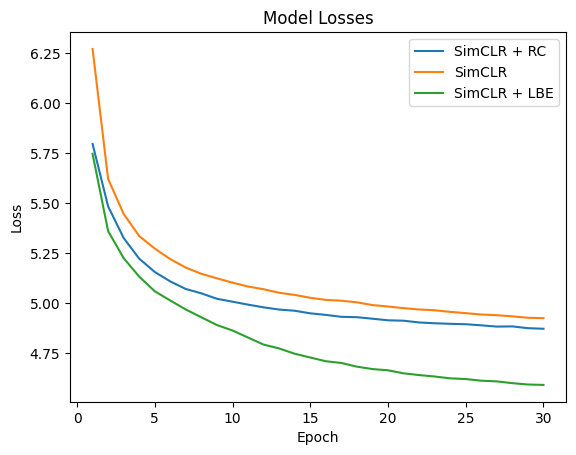

In [ ]:
import matplotlib.pyplot as plt

# Define your loss values for each model
model1_losses = [5.797138889019306, 5.484603649530655, 5.326670230963291, 5.223193144186949, 5.156870937347412, 5.109294336270064, 5.071587983155862, 5.049821726481119, 5.022656242664044, 5.008277736566005, 4.993439737955729, 4.979922458453056, 4.968852302355644, 4.962911847921518, 4.949985494369115, 4.942127875792674, 4.932570948967567, 4.930655325376071, 4.923004390031863, 4.915101765363644, 4.913053507682605, 4.904339650961069, 4.900300216674805, 4.897521280631041, 4.895509749192458, 4.889947695609851, 4.883710193634033, 4.884594215490879, 4.875672474885598, 4.872811131599622]

model2_losses = [6.272327550252279, 5.621863714853922, 5.447281529353215, 5.3363340989137305, 5.273751158592028, 5.220987363962027, 5.178464366228153, 5.147619782961332, 5.124963833735539, 5.1034412677471455, 5.084142709389711, 5.07044622470171, 5.052771257742857, 5.041964433132073, 5.027755984281883, 5.01721997872377, 5.013136528699826, 5.004942267980331, 4.991191744193053, 4.98416594236325, 4.975762367248535, 4.9693294378427355, 4.965312434465457, 4.957261332487449, 4.9509335346710985, 4.943993898538443, 4.940752508701422, 4.93480636645586, 4.927824722192226, 4.925734431927021]

model3_losses = [5.747309775230212, 5.361246272845146, 5.225735326913687, 5.1335507466242865, 5.060245284056053, 5.014018733684833, 4.968863389430902, 4.929931669968825, 4.891392641801101, 4.864063030634171, 4.828742971175756, 4.793576367696127, 4.7743206977844235, 4.747930954664182, 4.7289455731709795, 4.710396250700339, 4.701737313392835, 4.683246074578701, 4.671169973031068, 4.665059659419915, 4.64995560768323, 4.641148021893623, 4.634004475520207, 4.624818770090739, 4.621244545471974, 4.613050294533754, 4.60966236897004, 4.600691531254695, 4.593987222818228, 4.591921644944411]
# Create a figure and axis object for your plot
fig, ax = plt.subplots()

# Set the title and labels for your plot
ax.set_title('Model Losses')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Plot your loss values for each model
ax.plot(range(1, len(model1_losses)+1), model1_losses, label='SimCLR + RC')
ax.plot(range(1, len(model2_losses)+1), model2_losses, label='SimCLR')
ax.plot(range(1, len(model3_losses)+1), model3_losses, label='SimCLR + LBE')

# Add a legend to your plot
ax.legend()

# Display your plot
plt.show()
